In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import pickle
import inspect

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [21]:
# Load simulation data

survfiles = sorted(glob.glob('GOOD_72800turns/surv*.npy'))
qxsfiles = sorted(glob.glob('GOOD_72800turns/qxtuned*.npy'))
x_stdfiles = sorted(glob.glob('GOOD_72800turns/x_std*.npy'))
countfiles = sorted(glob.glob('GOOD_72800turns/count*.npy'))

survs = np.array([])
qxs = np.array([])
sigmax_growths = np.array([])
counts = []

for survfilei,qxfilei,x_stdfilei,countfilei in zip(survfiles,qxsfiles,x_stdfiles,countfiles):
    survi = np.load(survfilei)
    survs = np.append(survi,survs)

    qxi = np.load(qxfilei)
    qxs = np.append(qxi,qxs)

    x_stdi = np.load(x_stdfilei)
    sigmax_growthi = np.max(x_stdi)/x_stdi[0]
    sigmax_growths = np.append(sigmax_growthi,sigmax_growths)

    counti = np.load(countfilei)
    counts.append(counti)

    # break
counts = np.array(counts)
    

In [3]:
# Load experimental data (Part 1)

def fun_gauss(x,mu,sigma,amp,offset):
    # toret = amp*norm.pdf(x,loc = mu, scale = sigma)+offset
    toret = amp*np.exp(-np.square(x-mu)/(2*(sigma**2)))+offset
    return toret


In [4]:
# Load experimental data (Part 2)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import chi2
from lmfit import Model

files = ['07112023_STATIC_2TURNS.dat']

comphtunes = []
compvtunes = []
compsurvivals = []
compipmturns = []
compsigmas = []
allfits = {}

for fitting_fun,fitting_fun_str in zip([fun_gauss],['Gaussian']):
    fit_per_func = {}
    
    for file in files:
    
        # Open fileamd load data
        ifile = open(file, 'rb')
        data = pickle.load(ifile, encoding="bytes")
        
        # Go over all measurements
        for i in data.keys():

            # Retrieve beam intensity data
            timei = np.array(data[i]['time'])
            rbeami = np.array(data[i]['beam'])

            mask1 = (timei>=0.07)*(timei<=0.75)
            mask2 = rbeami>0.01
            mask = mask1*mask2

            timeimasked = timei[mask]
            rbeamimasked = rbeami[mask]

            compsurvivals.append(np.mean(rbeamimasked[-5:-1])/np.max(rbeamimasked))

            if fitting_fun_str == 'Gaussian':
                comphtunes.append(data[i]['htune'])
                compvtunes.append(data[i]['vtune'])

            #----------------------------
            # Retrieve IPM data and process that data
            ipmdatai = data[i]['ipm']
            compipmturni = []
            
            if fitting_fun_str == 'Gaussian':
                compsigmai = []
                emittancei = []

            # normalize = plt.Normalize(0, 15)
            # cmap = plt.colormaps["plasma"]

            # fig = plt.figure(figsize = (14,10)) 
            # ax = fig.add_subplot(projection='3d')

            fits = []
            # Go through every turn of data 
            for nturn, turndata in list(enumerate(ipmdatai)):

                # Create channel numbers 
                channels = np.arange(len(turndata))

                # Smooth channel data
                #turndata = savgol_filter(turndata, window_length=5, polyorder=3)

                # Just get positive count channel plates
                #channels = channels[turndata>0]
                #turndata = turndata[turndata>0]

                # Scale data 
                scaler = MinMaxScaler()
                scaler.fit(turndata.reshape(-1,1))
                yscaled = scaler.transform(turndata.reshape(-1,1)).reshape(1,-1).squeeze()
                #mu0 = np.average(channels, weights = yscaled)
                mu0 = channels[np.argmax(turndata)]
                sigma0 = 5

                # Fit data with corresponding fitting_function
                gmodel = Model(fitting_fun)

                # Get parameters from fitting function
                params = inspect.getfullargspec(fitting_fun)[0][1:]
                numparams = len(params)

                # Add parameters to fit instance
                for parameter in params:

                    if parameter == 'mu':
                        gmodel.set_param_hint('mu', value = mu0, min = 0, max = 80)

                    elif parameter == 'sigma':
                        gmodel.set_param_hint('sigma', value = sigma0, min = 1, max = 50)

                    elif parameter == 'amp':
                        amp0 = np.max(yscaled)
                        gmodel.set_param_hint('amp', value = amp0, min = 0.5*amp0, max = 1.5*amp0)

                    elif parameter == 'ai':
                        gmodel.set_param_hint('ai', value = 0, min = -1, max = 1)

                    elif parameter == 'offset':
                        offset0 = scaler.transform(np.mean(turndata[-40:]).reshape(-1, 1))
                        offset0 = float(offset0.squeeze())
                        gmodel.set_param_hint('offset', value = offset0, min = -0.1, max = 0.5)
                    
                    elif parameter == 'q':
                        qmin = -0.5
                        qmax = 2.9
                        gmodel.set_param_hint('q', value = 1.1, min = qmin, max = qmax)


                # Fit data and add to global array
                sigmai = 1.25*np.std(turndata[-20:])
                sigmaiforfit = float(scaler.transform(sigmai.reshape(-1, 1)).squeeze())
                fit = gmodel.fit(yscaled, x = channels, #nan_policy = 'omit',
                                 weights = (1.0/(scaler.scale_*sigmai))*np.ones_like(turndata))
                #fits.append(fit)
                datafit = scaler.inverse_transform((fit.best_fit).reshape(-1,1)).reshape(1,-1).squeeze()
                #print(fit.best_values)

#                 # Calculate residuals, chisqr and all that fun stuff from fit
#                 residualsi = (turndata - datafit)
#                 #print(sigmai)

#                 chisqri = np.sum(np.square(np.divide(residualsi,sigmai)))
#                 dof = len(turndata)-numparams
#                 redchisqri = chisqri/dof
#                 #print(redchisqri)
#                 #print(chisqri/fit.chisqr)
                
                chi2_95 = chi2.ppf(q = 0.95, df = fit.nfree)


                if (chi2_95>fit.chisqr) and (fit.values['mu']<40) and (fit.values['sigma']<50):
                #if (redchisqri < 5) and (fit.values['mu']<40):
                
                    # ax.scatter(channels,ys = np.zeros_like(yscaled) + nturn, 
                    #            zs = turndata, 
                    #            s = 10, alpha = 0.1, color = cmap(normalize(fit.best_values['sigma'])))
                    
                    if fitting_fun_str == 'Gaussian':
                        fits.append(fit)
                        compipmturni.append(nturn)
                        compsigmai.append(fit.best_values['sigma'])
                    
                    elif fitting_fun_str == 'qGaussian':
                        if (fit.values['q']<0.99*qmax) and (fit.values['q']>0.99*qmin):
                            compipmturni.append(nturn)
                            fits.append(fit)
                    
                    # ax.plot(channels, ys = np.zeros_like(yscaled) + nturn, zs = datafit,
                    #         color = cmap(normalize(fit.best_values['sigma'])))
                    
                    #break


                #print(redchisqri)

                #break

            if fitting_fun_str == 'Gaussian':
                compipmturns.append(compipmturni)
                compsigmas.append(compsigmai)

            #ax.set_zlim(0,1000)
            #ax.set_ylim(0,100)

            # ax.tick_params(axis='x', labelsize=16, pad = 6)
            # ax.tick_params(axis='y', labelsize=16, pad = 10)
            # ax.tick_params(axis='z', labelsize=16, pad = 12)

            # ax.set_title(fitting_fun_str+' Fit \n($Q_x$ = %.3f, $Q_y$ = %.3f)'%(data[i]['htune'],data[i]['vtune']), fontsize = 35, y=1.0, pad=-30)
            # ax.set_ylabel('\n' + 'Turns*',fontsize=30, linespacing =3)
            # ax.set_xlabel('\n' +'Channel Number',fontsize=30, linespacing =3)
            # ax.set_zlabel('\n' + 'Counts',fontsize=30, linespacing =3)
            #ax.zaxis.labelpad=10

            # normalize = plt.Normalize(0, 0.5*15)
            # cbar = fig.colorbar(cm.ScalarMappable(norm=normalize, cmap=cmap), 
            #                     ax=ax, shrink = 0.6,pad = 0.03)
            # cbar.set_label('Beam Size $\sigma_x$ [mm]',fontsize = 26)
            # cbar.ax.tick_params(axis='y', labelsize = 14)

            # ax.xaxis.pane.fill = False # Left pane
            # ax.yaxis.pane.fill = False # Right pane

            # ax.grid(False)
            # ax.set_box_aspect(aspect=None, zoom=0.8)
            # ax.view_init(20, -70)

            # fig.patch.set_facecolor('white')
            # #fig.savefig('%s.png'%str(tune))
            # #plt.tight_layout()
            # plt.show()
            # plt.close()

            #break
            fit_per_func[i] = {}
            fit_per_func[i]['fits']=fits
            fit_per_func[i]['turns']=compipmturni
            fit_per_func[i]['htune']=data[i]['htune']
            fit_per_func[i]['vtune']=data[i]['vtune']
            
            # if i == 6:
            #     break
    
    allfits[fitting_fun_str] = fit_per_func


In [5]:
# Load experimental data (Part 3)

collapsed_htune = np.unique(comphtunes)
collapsed_sigmas = []
collapsed_survive = []
collapsed_survive_std = []
collapsed_turns = []

for tune in collapsed_htune:
    
    sigmapertune = np.array([])
    survivepertune = np.array([]) 
    turnpertune = np.array([])
    
    for tunei,sigmalisti,survi,turnj in zip(comphtunes,compsigmas,compsurvivals,compipmturns):
        
        if tunei==tune:
            
            turnpertune = np.concatenate((turnpertune,turnj))
            sigmapertune = np.concatenate((sigmapertune,sigmalisti))
            survivepertune = np.append(survivepertune,survi)
            
    # Introduce 0.5 mm for MCP resolution
    collapsed_sigmas.append(0.5*sigmapertune)
    collapsed_survive.append(np.mean(survivepertune))
    collapsed_survive_std.append(np.std(survivepertune))
    collapsed_turns.append(turnpertune)

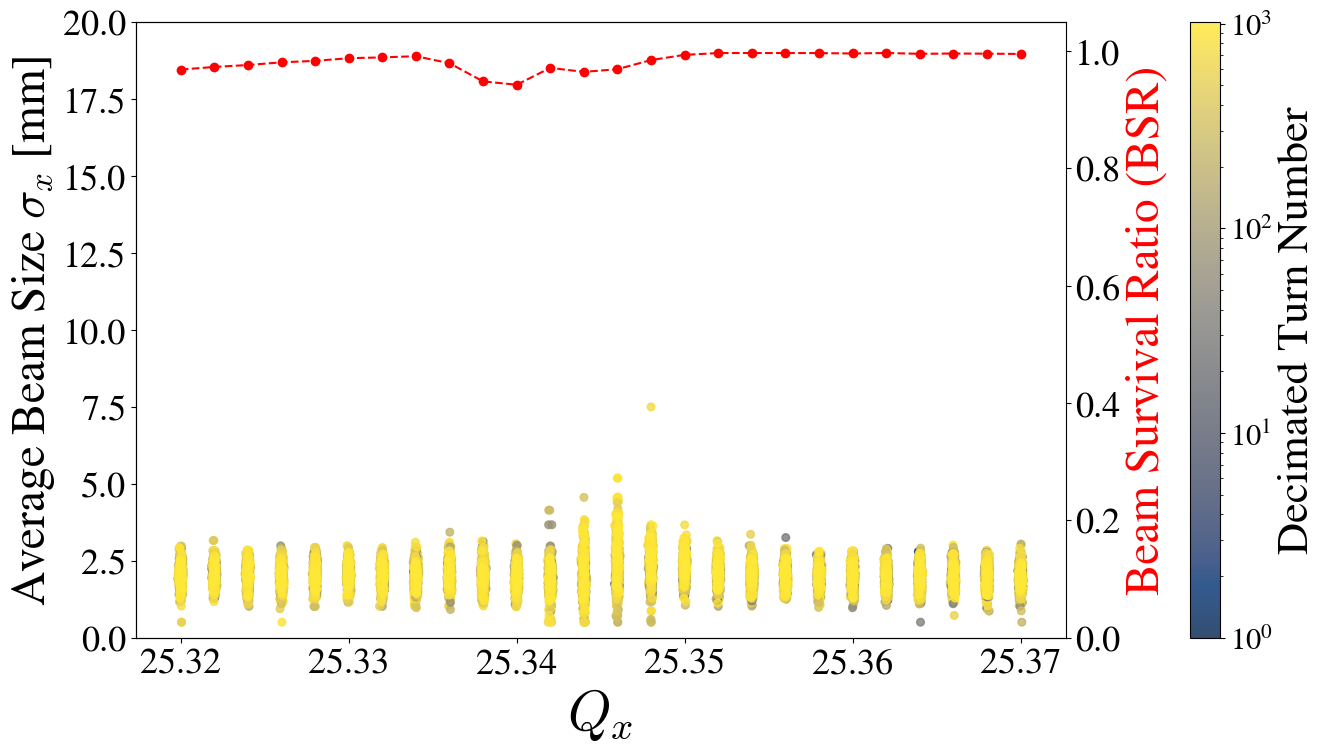

In [26]:
fig,ax = plt.subplots(1,1,figsize=(16,8))

normalize = plt.Normalize(0, 100)
cmap = plt.colormaps["cividis"]

axt = ax.twinx()
axt.errorbar(x = collapsed_htune,y = collapsed_survive, yerr = collapsed_survive_std,
             fmt = 'o--',c = 'red',label = 'BSR')

axt.set_ylabel('Beam Survival Ratio (BSR)', fontsize = 34, color = 'red')
axt.set_ylim(0.0,1.05)
axt.tick_params(axis='both', labelsize=26)

#plt.legend()
ax.set_ylim(-0.,2.5)
ax.tick_params(axis='both', labelsize=26)
ax.set_xlabel(r'$Q_x$',fontsize=40)
ax.set_ylabel('Average q-factor',fontsize= 34)

axtt = ax

for htunei,ei,turnsi in zip(collapsed_htune,collapsed_sigmas,collapsed_turns): 
    s = axtt.scatter((np.ones_like(htunei)*htunei+0.005*np.random.normal(loc = 0.0, scale = 0.01,size = len(ei))),ei, 
                   s = 30,c = turnsi, cmap = cmap, norm = matplotlib.colors.LogNorm(), label = 'Beam Size',alpha = 0.8)

axtt.set_ylim(0,20)
axtt.spines.right.set_position(("axes", 1.15))
axtt.set_ylabel(r'Average Beam Size $\sigma_x$ [mm]',fontsize= 34)
axtt.tick_params(axis='both', labelsize=26)

cbar = fig.colorbar(s, ax=ax, pad = 0.1)
cbar.set_label('Decimated Turn Number',fontsize = 32)
cbar.ax.tick_params(axis='y', labelsize = 22)

h,l = ax.get_legend_handles_labels()
hh,ll = axt.get_legend_handles_labels()
hhh,lll = axtt.get_legend_handles_labels()
# ax.legend([h[1],hh[-1],hhh[-1]],[l[1],ll[-1],lll[-1]],loc = (0.66,0.66),fontsize = 22)

plt.show()
plt.close()

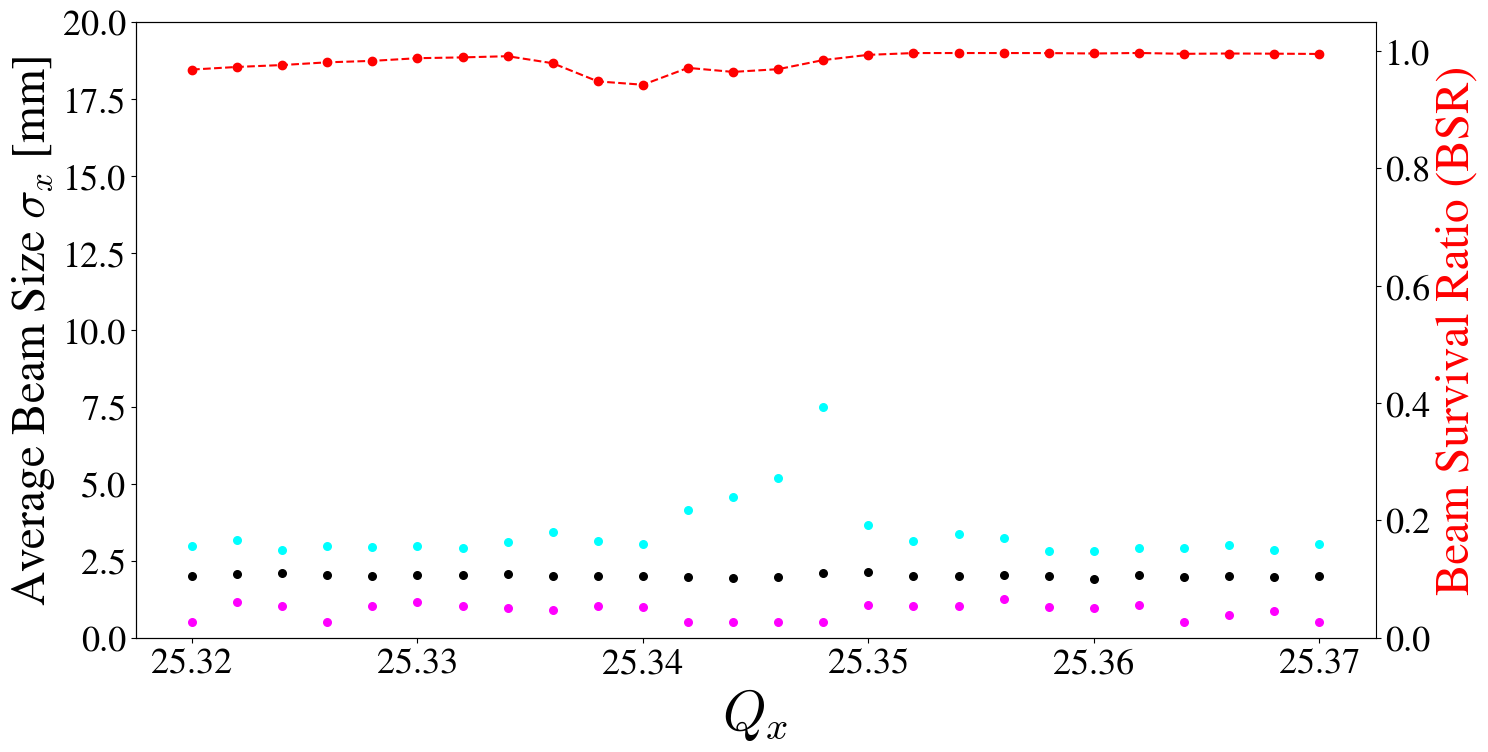

In [7]:
fig,ax = plt.subplots(1,1,figsize=(16,8))

normalize = plt.Normalize(0, 100)
cmap = plt.colormaps["cividis"]

axt = ax.twinx()
axt.errorbar(x = collapsed_htune,y = collapsed_survive, yerr = collapsed_survive_std,
             fmt = 'o--',c = 'red',label = 'BSR')

axt.set_ylabel('Beam Survival Ratio (BSR)', fontsize = 34, color = 'red')
axt.set_ylim(0.0,1.05)
axt.tick_params(axis='both', labelsize=26)

#plt.legend()
ax.set_ylim(-0.,2.5)
ax.tick_params(axis='both', labelsize=26)
ax.set_xlabel(r'$Q_x$',fontsize=40)
ax.set_ylabel('Average q-factor',fontsize= 34)

axtt = ax

for htunei,si,turnsi in zip(collapsed_htune,collapsed_sigmas,collapsed_turns): 

    axtt.scatter([htunei],[np.mean(si[:100])], s = 30, c = 'k')
    axtt.scatter([htunei],[np.max(si)], s = 30, c = 'cyan')
    axtt.scatter([htunei],[np.min(si)], s = 30, c = 'fuchsia')
    
    # s = axtt.scatter((np.ones_like(htunei)*htunei+0.005*np.random.normal(loc = 0.0, scale = 0.01,size = len(ei))),ei, 
    #                s = 30,c = turnsi, cmap = cmap, norm = matplotlib.colors.LogNorm(), label = 'Beam Size',alpha = 0.8)

axtt.set_ylim(0,20)
axtt.spines.right.set_position(("axes", 1.15))
axtt.set_ylabel(r'Average Beam Size $\sigma_x$ [mm]',fontsize= 34)
axtt.tick_params(axis='both', labelsize=26)

# cbar = fig.colorbar(s, ax=ax, pad = 0.1)
# cbar.set_label('Decimated Turn Number',fontsize = 32)
# cbar.ax.tick_params(axis='y', labelsize = 22)

h,l = ax.get_legend_handles_labels()
hh,ll = axt.get_legend_handles_labels()
hhh,lll = axtt.get_legend_handles_labels()
# ax.legend([h[1],hh[-1],hhh[-1]],[l[1],ll[-1],lll[-1]],loc = (0.66,0.66),fontsize = 22)

plt.show()
plt.close()

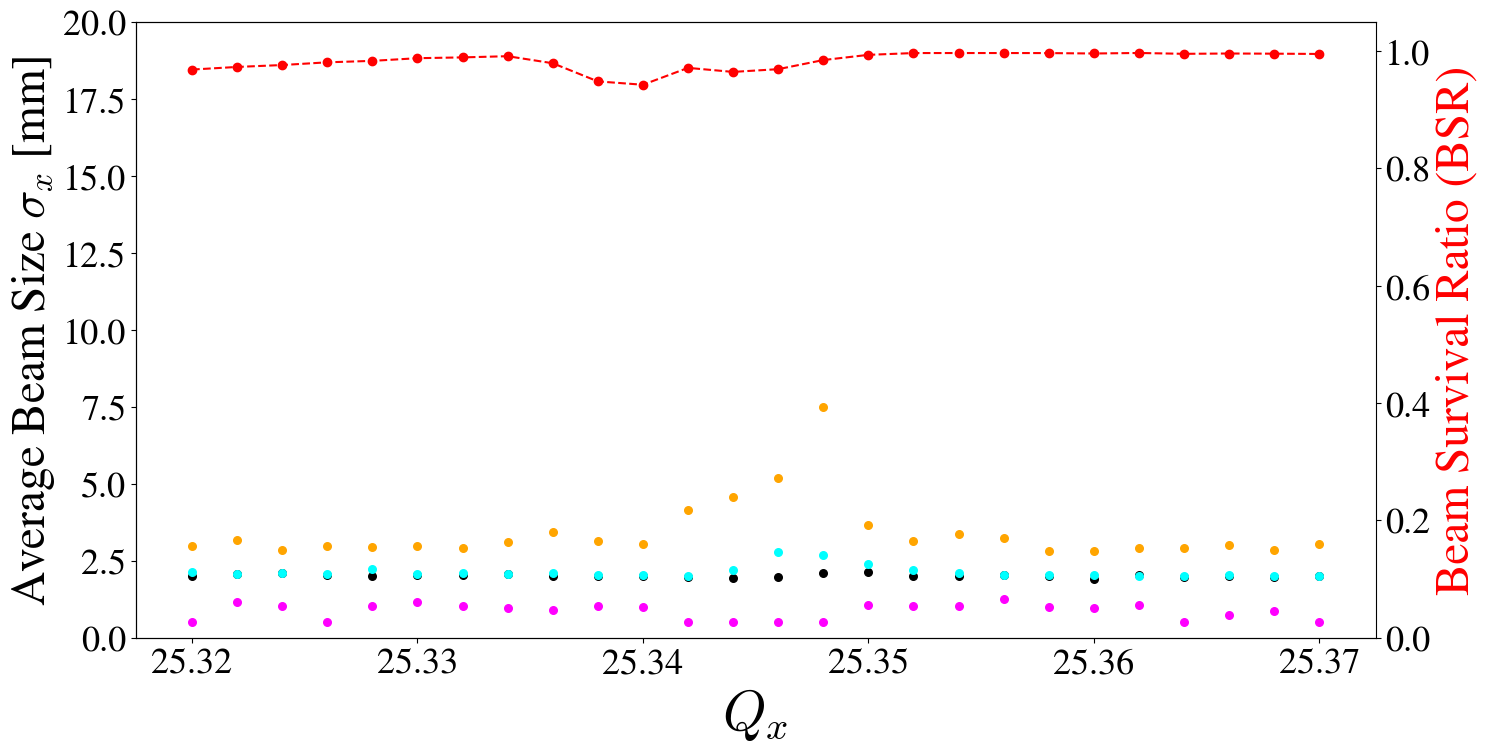

In [8]:
fig,ax = plt.subplots(1,1,figsize=(16,8))

normalize = plt.Normalize(0, 100)
cmap = plt.colormaps["cividis"]

axt = ax.twinx()
axt.errorbar(x = collapsed_htune,y = collapsed_survive, yerr = collapsed_survive_std,
             fmt = 'o--',c = 'red',label = 'BSR')

axt.set_ylabel('Beam Survival Ratio (BSR)', fontsize = 34, color = 'red')
axt.set_ylim(0.0,1.05)
axt.tick_params(axis='both', labelsize=26)

#plt.legend()
ax.set_ylim(-0.,2.5)
ax.tick_params(axis='both', labelsize=26)
ax.set_xlabel(r'$Q_x$',fontsize=40)
ax.set_ylabel('Average q-factor',fontsize= 34)

axtt = ax

for htunei,si,turnsi in zip(collapsed_htune,collapsed_sigmas,collapsed_turns):

    fit = np.polyfit(turnsi,si,7)
    poly = np.poly1d(fit)
    
    xspace = np.arange(0,1024)
    sspace = poly(xspace)

    axtt.scatter([htunei],[np.mean(si[:100])], s = 30, c = 'k')
    axtt.scatter([htunei],[np.max(sspace)], s = 30, c = 'cyan')
    axtt.scatter([htunei],[np.max(si)], s = 30, c = 'orange')
    axtt.scatter([htunei],[np.min(si)], s = 30, c = 'fuchsia')
    
    # s = axtt.scatter((np.ones_like(htunei)*htunei+0.005*np.random.normal(loc = 0.0, scale = 0.01,size = len(ei))),ei, 
    #                s = 30,c = turnsi, cmap = cmap, norm = matplotlib.colors.LogNorm(), label = 'Beam Size',alpha = 0.8)

axtt.set_ylim(0,20)
axtt.spines.right.set_position(("axes", 1.15))
axtt.set_ylabel(r'Average Beam Size $\sigma_x$ [mm]',fontsize= 34)
axtt.tick_params(axis='both', labelsize=26)

# cbar = fig.colorbar(s, ax=ax, pad = 0.1)
# cbar.set_label('Decimated Turn Number',fontsize = 32)
# cbar.ax.tick_params(axis='y', labelsize = 22)

h,l = ax.get_legend_handles_labels()
hh,ll = axt.get_legend_handles_labels()
hhh,lll = axtt.get_legend_handles_labels()
# ax.legend([h[1],hh[-1],hhh[-1]],[l[1],ll[-1],lll[-1]],loc = (0.66,0.66),fontsize = 22)

plt.show()
plt.close()

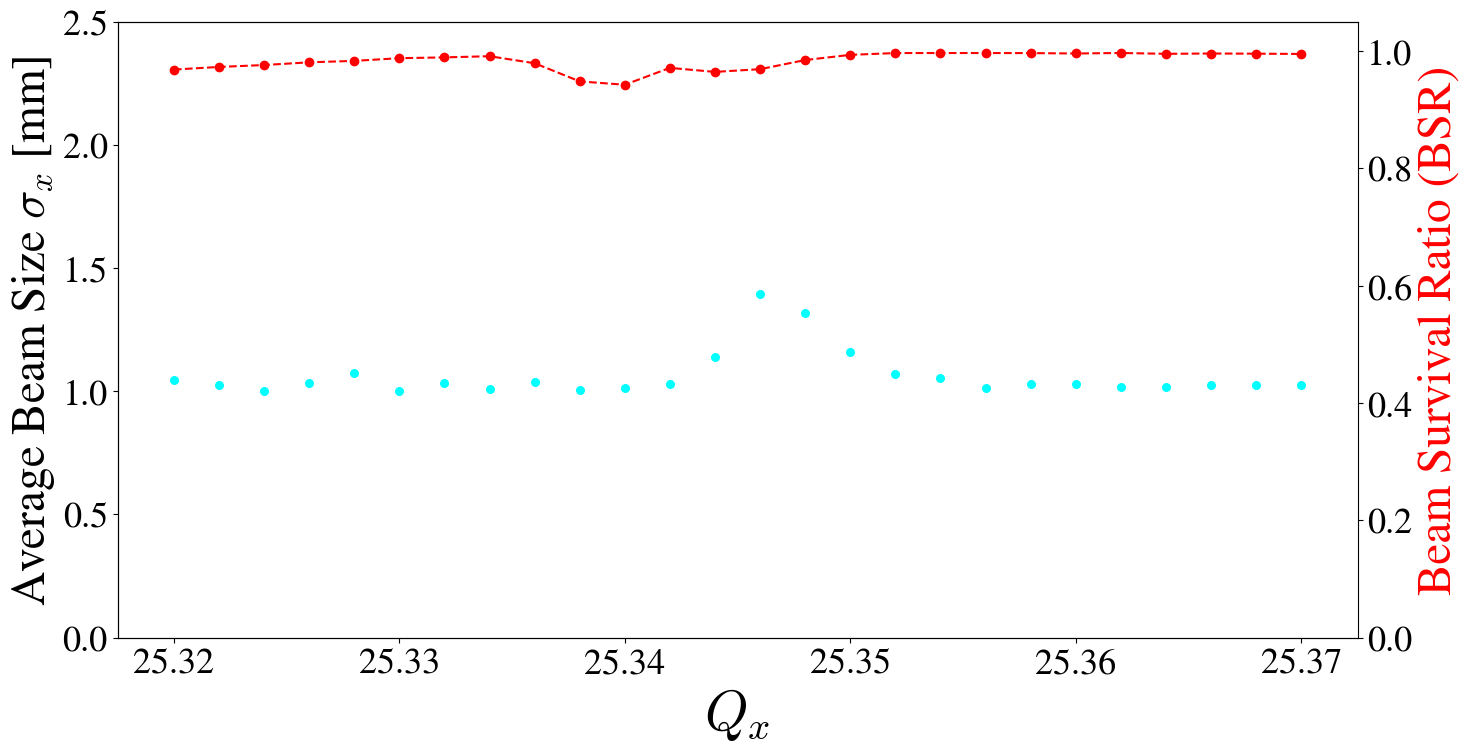

In [9]:
fig,ax = plt.subplots(1,1,figsize=(16,8))

normalize = plt.Normalize(0, 100)
cmap = plt.colormaps["cividis"]

axt = ax.twinx()
axt.errorbar(x = collapsed_htune,y = collapsed_survive, yerr = collapsed_survive_std,
             fmt = 'o--',c = 'red',label = 'BSR')

axt.set_ylabel('Beam Survival Ratio (BSR)', fontsize = 34, color = 'red')
axt.set_ylim(0.0,1.05)
axt.tick_params(axis='both', labelsize=26)

#plt.legend()
ax.set_ylim(-0.,2.5)
ax.tick_params(axis='both', labelsize=26)
ax.set_xlabel(r'$Q_x$',fontsize=40)
ax.set_ylabel('Average q-factor',fontsize= 34)

axtt = ax

for htunei,si,turnsi in zip(collapsed_htune,collapsed_sigmas,collapsed_turns):

    fit = np.polyfit(turnsi,si,7)
    poly = np.poly1d(fit)
    
    xspace = np.arange(0,1024)
    sspace = poly(xspace)

    # axtt.scatter([htunei],[np.mean(si[:100])], s = 30, c = 'k')
    axtt.scatter([htunei],[np.max(sspace)/np.mean(sspace[:100])], s = 30, c = 'cyan')
    
    # s = axtt.scatter((np.ones_like(htunei)*htunei+0.005*np.random.normal(loc = 0.0, scale = 0.01,size = len(ei))),ei, 
    #                s = 30,c = turnsi, cmap = cmap, norm = matplotlib.colors.LogNorm(), label = 'Beam Size',alpha = 0.8)

# axtt.set_ylim(0,20)
axtt.spines.right.set_position(("axes", 1.15))
axtt.set_ylabel(r'Average Beam Size $\sigma_x$ [mm]',fontsize= 34)
axtt.tick_params(axis='both', labelsize=26)

# cbar = fig.colorbar(s, ax=ax, pad = 0.1)
# cbar.set_label('Decimated Turn Number',fontsize = 32)
# cbar.ax.tick_params(axis='y', labelsize = 22)

h,l = ax.get_legend_handles_labels()
hh,ll = axt.get_legend_handles_labels()
hhh,lll = axtt.get_legend_handles_labels()
# ax.legend([h[1],hh[-1],hhh[-1]],[l[1],ll[-1],lll[-1]],loc = (0.66,0.66),fontsize = 22)

plt.show()
plt.close()

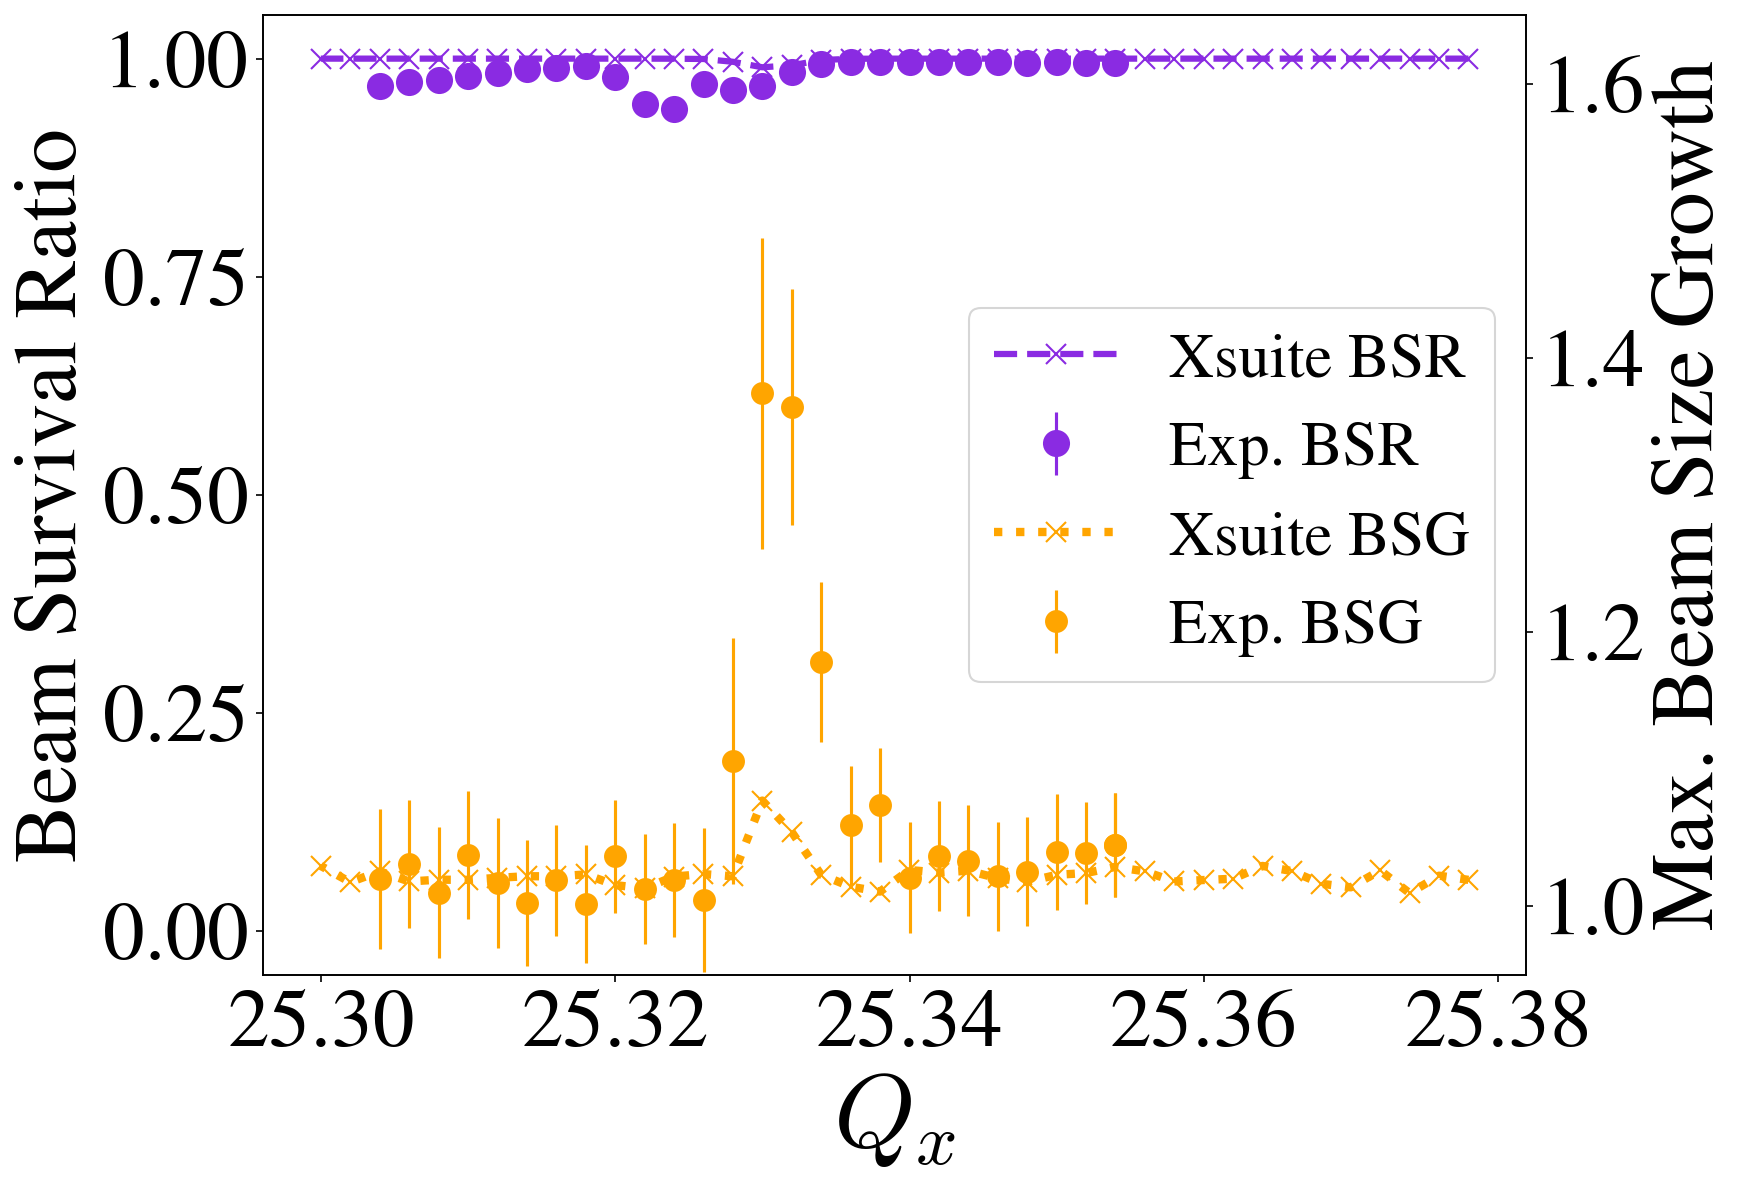

In [27]:
fig,ax = plt.subplots(1,1,figsize = (11.75,8))

fig.set_dpi(150)

ax.plot(qxs,survs, marker = 'x', linewidth = 3,markersize = 10,linestyle = '--', color = 'blueviolet',label = 'Xsuite BSR')

ax.errorbar(x = collapsed_htune-0.016,y = collapsed_survive, yerr = collapsed_survive_std, label = 'Exp. BSR',
             color = 'blueviolet', fmt = 'o', markersize =12)

axt.set_ylabel('Beam Survival Ratio (BSR)', fontsize = 34, color = 'red')

ax.set_xlabel(r'$Q_x$',fontsize =50)
ax.set_ylabel(r'Beam Survival Ratio',fontsize =42)

ax.tick_params(axis='both', labelsize=40)

axt = ax.twinx()

axt.plot(qxs,sigmax_growths, c = 'orange', marker = 'x',linestyle = 'dotted',linewidth = 4,markersize = 10, label = 'Xsuite BSG')

for htunei,si,turnsi in zip(collapsed_htune,collapsed_sigmas,collapsed_turns):

    fit = np.polyfit(turnsi,si,8)
    poly = np.poly1d(fit)
    
    xspace = np.arange(0,1024)
    sspace = poly(xspace)

    serror = 3*2*np.std(si)/np.sqrt(len(si))

    # axtt.scatter([htunei],[np.mean(si[:100])], s = 30, c = 'k')
    axt.errorbar([htunei-0.016],[np.max(sspace)/np.mean(sspace[:50])],yerr = serror, fmt = 'o',
                 markersize = 10, c = 'orange')

axt.errorbar([htunei-0.016],[np.max(sspace)/np.mean(sspace[:50])], yerr = serror, fmt = 'o', markersize = 10, c = 'orange',label = 'Exp. BSG')

lt,ht = axt.get_legend_handles_labels()
legends,handles = ax.get_legend_handles_labels()

legends.append(lt[0])
handles.append(ht[0])

legends.append(lt[1])
handles.append(ht[1])

ax.legend(legends,handles,loc = 'center right', fontsize = 30)

ax.set_ylim(-0.05,1.05)
axt.set_ylim(0.95,1.65)

# axt.set_ylabel(r'$\sigma_{x,MAX} / \sigma_{x,0}$',fontsize =42)
axt.set_ylabel(r'Max. Beam Size Growth',fontsize =42)

axt.tick_params(axis='both', labelsize=40)

plt.tight_layout()
fig.savefig('static2turns_comp.pdf')

plt.show()
plt.close()

In [19]:
x_stdi

array([0.00243748, 0.00242209, 0.00241698, ..., 0.00243899, 0.00243507,
       0.00241586])

In [20]:
si

array([1.12503211, 1.85619489, 1.55170185, ..., 1.69208209, 2.00107239,
       2.03119612])